## Imports

In [1]:
import tensorflow as tf
assert int(tf.__version__[0]) >= 2 #Must use tensorflow V 2.0 or later

In [2]:
import torch # PSO
import re #Regex to remove unneeded layers
import time # Time Tracking
import os #File Downloading
import numpy as np #For pyswarms parameters & output
import matplotlib.pyplot as plt #For output Images
import glob #Image Gan
import imageio #Image Gan
import PIL #Image Gan
from tensorflow.keras import layers #For models
from IPython import display # Notebook display

## Constants

In [3]:
# Number of generators
NP = 5
#Number of Epochs
NT = 50
#Number of images per batch
BATCH_SIZE = 256
# Number of elements stored in buffer
BUFFER_SIZE = 60000
# Seed for Viewing Training images
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
SEED = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

## GAN Functions

### Generator

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

In [5]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5 ), strides = (2, 2), padding = 'same',
                           input_shape = [28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [7]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## PSO Functions

In [ ]:
# Main Class for Particle Swarm Optimization
class AcceleratedParticleSwarmOptimizer(object):
    def __init__(self,swarm_size=100,options=None):
        if (options == None):
            options = [2.,2.,0.9,.95,100]
        self.swarm_size = swarm_size
        self.set_options(options)

    def optimize(self,function):
        self.fitness_function = function

    def search_space(self,upper_bound,lower_bound):
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.dimensionality = upper_bound.size()[0]

    def populate(self):
        self.position = ((self.upper_bound - self.lower_bound)*torch.rand(1,self.swarm_size)) + self.lower_bound
        self.scaling = self.upper_bound - self.lower_bound
        self.velocity = torch.randn([self.dimensionality,self.swarm_size]) * self.scaling * 0.1  # could also set to zeros, but one particle gets stuck in local/global best initially
        
    def init(self):
        self.current_fitness = self.fitness_function(self.position)
        self.p_best = torch.clone(self.position).detach()
        self.p_best_fitness = torch.clone(self.current_fitness).detach()
        self.global_best = torch.clone(self.position[:,self.current_fitness.argmin()].view(self.dimensionality,1)).detach()
        self.global_best_fitness = self.current_fitness.min()

    def enforce_bounds(self):
        upper_bound = self.upper_bound.view(self.dimensionality,1)
        lower_bound = self.lower_bound.view(self.dimensionality,1)
        self.position = torch.max(torch.min(self.position,upper_bound),lower_bound)
        
    def set_options(self, options):
        self.c1 = options[0]
        self.c2 = options[1]
        self.w = options[2]
        self.alpha = options[3]
        self.max_iterations = options[4]
        
    def update_fitness(self):
        #calculate fitness
        self.current_fitness = self.fitness_function(self.position)

        #udpate particle bests
        self.p_best = torch.where(self.current_fitness < self.p_best_fitness, self.position, self.p_best)    # MUST update these two in this order (p_best THEN p_best_fitness) 
        self.p_best_fitness = torch.where(self.current_fitness < self.p_best_fitness, self.current_fitness, self.p_best_fitness)  # since fitness is used as cond. in first

        #update global bests
        if (self.current_fitness.min() < self.global_best_fitness):
            self.global_best_fitness = self.current_fitness.min()
            self.global_best = torch.clone(self.position[:,self.current_fitness.argmin()].view(self.dimensionality,1))
        
    def update_positions(self):
        #self.scaling = self.upper_bound - self.lower_bound    #scaling is already calculated in populate, do we need to do so again?
        self.position = self.position + self.velocity
        self.enforce_bounds()
    
    def update_velocity(self):
        self.velocity = self.w*self.velocity + self.c1*(self.global_best-self.position)*torch.rand([self.dimensionality,self.swarm_size]) 
        + self.c2*(self.p_best-self.position)*torch.rand([self.dimensionality,self.swarm_size]) 
        self.w = self.w * self.alpha
        #self.enforce_bounds()   # bounds enforcement should just be in position, unless we decide to do velocity clipping later, then we should just make a new function for efficiency.
               
    def update_global_best(self, new_fitness):
        self.global_best_fitness = new_fitness

In [9]:
#Stores fitness of each model
class ParticleFitness():
    def __init__(self, num_gen):
        self.fitness = torch.from_numpy(np.full(num_gen, np.inf))
        
    def update(self, x, new_fitness):
        self.fitness[x] = float(new_fitness.numpy())
    
    def fitness_func(self, x):
        return self.fitness

## Swap values between Generator & PSO Functions

In [10]:
#Returns layers to be trained by PSO
def find_trainable_layers(model):
    trainable = []
    x = 0
    for layer in global_best_generator.layers:
        #Removes BatchNormalization, LeakyRelu, and Reshape layers from PSO
        if re.match("<.*\.[BLR]\w+.*", str(layer)) is  None:
            trainable.append(x)
        x+=1
    return trainable

In [11]:
#Returns shapes of given layers
def get_shapes(model, layers):
    shapes = []
    for x in layers:
        for s in model.layers[x].get_weights():
            shapes.append(s.shape)
    return shapes

In [12]:
#Returns total number of perceptrons in shapes of layers
def get_size(shapes):
    new_weights = []
    total_size = 0
    for layer in shapes:
        size = 1
        for dim in layer:
            size *= dim
        total_size += size
    return total_size

In [13]:
#Traverses each layer and updates the weights to new values
def update_weights(layer, dimensions, total_size):
    new_weights = []
    size = 1
    for dim in layer:
        size *= dim
    new_weights.append(dimensions[total_size:total_size+size].reshape(layer))
    total_size += size
    return new_weights, total_size

## REWRITE

In [14]:
#Recursively sets initial PSO values to those created by model
def init_swarm(weights):
    dimensions = np.ndarray(ND)
    count = 0
    dimension, count = swarm_recurs(weights, dimensions, count)
    return dimensions

In [15]:
#Recursive portion of init_swarm
def swarm_recurs(weights, dimensions, count):
    for x in range(len(weights)):
        if type(weights[x]) != np.ndarray and type(weights[x]) != list:
            dimensions[count] = weights[x]
            count+=1
        else:
            dimensions, count = swarm_recurs(weights[x], dimensions, count)
    return dimensions, count

## Training Functions

In [16]:
#Creates an image with constant noise
def generate_image(model):
    noise = tf.random.normal([1, 100])
    generated_image = model(noise, training = False)

    plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [17]:
#Creates random images and saves to file
def generate_and_save_images(model, Nt, test_input):
    predictions = model(test_input, training = False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(Nt))
    plt.show()

In [18]:
#@tf.function
def train_step(images, epoch):
    disc_loss = []
    noiseshape = tf.random.normal([1, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        for x in range(len(generator)):       
            generated_images = generator[x](noise, training = True)

            real_output = discriminator(images, training = False)
            fake_output = discriminator(generated_images, training = False)
            
            disc_loss.append(discriminator_loss(real_output, fake_output))
            print("Generator: " + str(x) +", Loss " + str(generator_loss(fake_output).numpy()))
            particle_fitness.update(x, generator_loss(fake_output))
        
        avg_disc_loss = tf.math.reduce_mean(disc_loss, axis=0)
        print("Discriminator Loss: " + str(avg_disc_loss))
    gradients_of_disccriminator = disc_tape.gradient(avg_disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_disccriminator, discriminator.trainable_variables))
    
    p.update_global_best(generator_loss(discriminator(global_best_generator(noise, training = False), training = False)))
    p.update_fitness()
    p.update_velocity()
    p.update_positions()
    positions = p.position.transpose(0, 1)
    for x in range(len(generator)):
        layer_num = 0
        for layer in trainable_layers:
            total_size = 0
            new_layer, total_size = update_weights(SHAPES[layer_num], positions[x], total_size)
            generator[x].layers[layer].set_weights(new_layer)
            layer_num+=1
    layer_num = 0
    for layer in trainable_layers:
        total_size = 0
        new_layer, total_size =  update_weights(SHAPES[layer_num], p.global_best.transpose(0,1)[0], total_size)
        global_best_generator.layers[layer].set_weights(new_layer)
        layer_num +=1

In [19]:
def train(dataset, Nt):
    for epoch in range(Nt):
        start = time.time()
        counter = 1
        for image_batch in dataset:
            print("Batch: " + str(counter))
            train_step(image_batch, epoch)
            
            display.clear_output(wait=True)
            generate_and_save_images(global_best_generator, epoch + 1, SEED)
            
            if(epoch + 1) % 15 == 0:
                checkpoint.save(file_prefix = checkpoint_prefix)
                
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            counter+=1
            
        display.clear_output(wait=True)
        generate_and_save_images(global_best_generator, epoch + 1, SEED)

## Download & Create Datasets

In [20]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [21]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create Models

In [23]:
generator = []
for _ in range(NP):
    generator.append(make_generator_model())
discriminator = make_discriminator_model()
global_best_generator = make_generator_model()

## Load Pretrained Discriminator

In [24]:
# Find way to load file into complex nested arrays

## Test Generator

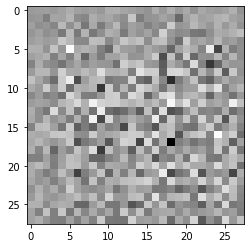

In [25]:
generate_image(generator[0])

## Create Optimizers

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Calculate number of weights

In [28]:
trainable_layers = find_trainable_layers(generator[0])

In [29]:
SHAPES = get_shapes(generator[0], trainable_layers)

In [30]:
ND = get_size(SHAPES)

## Create PSO

In [31]:
upper_bound = torch.ones(ND,1)*10
lower_bound = torch.ones(ND,1)*(-10)
particle_fitness = ParticleFitness(NP)
p = AcceleratedParticleSwarmOptimizer(NP, options=[2.05, 2.05, .9, .95, 100])
p.optimize(particle_fitness.fitness_func)
p.search_space(upper_bound,lower_bound)

## Sync Generator Weights to PSO

In [32]:
p.populate()

In [33]:
weights = []
for x in trainable_layers:
    weights.append(global_best_generator.layers[x].get_weights())

In [34]:
positions =  p.position.transpose(0, 1)
for x in range(len(generator)):
    positions[x] = torch.from_numpy(init_swarm(weights))
    
p.position = positions.transpose(0, 1)

In [35]:
p.init()

## Train

In [36]:
noise = tf.random.normal([1, 100])

In [37]:
train(train_dataset, NT)

Batch: 1
Generator: 0, Loss 0.6931472
Generator: 1, Loss 0.6931472
Generator: 2, Loss 0.6931472
Generator: 3, Loss 0.6931472
Generator: 4, Loss 0.6931472
Discriminator Loss: tf.Tensor(1.3953682, shape=(), dtype=float32)


TypeError: where(): argument 'condition' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
generate_image(global_best_generator)